Leveraging GANs for Road intersection detection

In [1]:
# supress warnings
import warnings
import numpy as np

warnings.filterwarnings("ignore")

In [75]:
import argparse
import copy
import gc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
import os
import random
from tqdm import tqdm
import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchvision.utils import save_image
import timeit
from PIL import Image

In [92]:
class CustomDataset(Dataset):
    def __init__(self, images, steering_values, transform=None):
        self.images = images
        self.steering_values = steering_values
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        steering_value = self.steering_values[idx]

        if self.transform:
            image = self.transform(image)

        return image, steering_value

In [93]:
class CarlaSteeringDataset(Dataset):
    def __init__(
        self, root_dir, steer_file, train_size=0.8, transform=None, random_state=42
    ):
        self.root_dir = root_dir
        self.image_filenames = sorted(os.listdir(root_dir))
        self.steer_values = np.loadtxt(steer_file)  # Load steering angle values

        self.image_filenames = [
            self.image_filenames[i] for i in range(0, len(self.image_filenames), 5)
        ]

        # Perform train-test split
        train_indices, test_indices = train_test_split(
            np.arange(len(self.image_filenames)),
            train_size=train_size,
            random_state=random_state,
        )

        self.train_image_filenames = [self.image_filenames[i] for i in train_indices]
        self.test_image_filenames = [self.image_filenames[i] for i in test_indices]

        self.train_steer_values = self.steer_values[train_indices]
        self.test_steer_values = self.steer_values[test_indices]

        self.transform = transform

    def __len__(self):
        return len(self.train_image_filenames) + len(self.test_image_filenames)

    def __getitem__(self, idx):
        if idx < len(self.train_image_filenames):
            image_filename = self.train_image_filenames[idx]
            steer_value = self.train_steer_values[idx]
        else:
            test_idx = idx - len(self.train_image_filenames)
            image_filename = self.test_image_filenames[test_idx]
            steer_value = self.test_steer_values[test_idx]

        img_name = os.path.join(self.root_dir, image_filename)
        try:
            image = Image.open(img_name)
        except FileNotFoundError:
            print(f"Error: File not found: {img_name}")
            return None, None  # Return None if image file not found

        if self.transform:
            image = self.transform(image)

        return image, steer_value


# Define paths
root_dir = "Carla/Images"
steer_file = "Carla/SteerValues/steer_values.txt"

# Define transformations
transform = transforms.Compose(
    [
        # transforms.Resize((224, 224)),  # Resize images to a consistent size
        transforms.ToTensor(),  # Convert images to PyTorch tensors
    ]
)

# Create dataset instance
dataset = CarlaSteeringDataset(root_dir, steer_file, transform=transform)

# Create dataset instance
# dataset = CarlaSteeringDataset(root_dir, steer_file, transform=transform)

# Access training and testing image filenames and steering values from the dataset
image_train_filenames, steer_train_values = (
    dataset.train_image_filenames,
    dataset.train_steer_values,
)
image_test_filenames, steer_test_values = (
    dataset.test_image_filenames,
    dataset.test_steer_values,
)

# # Create separate datasets for training and testing
# train_dataset = CustomDataset(
#     images=image_train_filenames,
#     steering_values=steer_train_values,
#     transform=transform,
# )
# test_dataset = CustomDataset(
#     images=image_test_filenames, steering_values=steer_test_values, transform=transform
# )

# Print the sizes of the train and test datasets
# print(f"Train dataset size: {len(train_dataset)}")
# print(f"Test dataset size: {len(test_dataset)}")

In [94]:
from keras.preprocessing.image import load_img, img_to_array, save_img
images=[]
labels=[]
for idx, img_filename in enumerate(image_train_filenames):
    img_path = "Carla/Images/" + img_filename
    img = load_img(img_path, target_size=(64, 64))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values
    images.append(img_array)
    label= np.array([steer_train_values[idx]])
    labels.append(label)

In [85]:
# remove too small angles and too large angles
q1 = -80
q2 = 80
indx = np.where((labels>q1)*(labels<q2)==True)[0]
labels = labels[indx]
images = images[indx]
assert len(labels)==len(images)

In [86]:
# for each angle, take no more than args.max_num_img_per_label images
image_num_threshold = 9999
print("\n Original set has {} images; For each angle, take no more than {} images>>>".format(len(images), image_num_threshold))
unique_labels_tmp = np.sort(np.array(list(set(labels))))
for i in tqdm(range(len(unique_labels_tmp))):
    indx_i = np.where(labels == unique_labels_tmp[i])[0]
    if len(indx_i)>image_num_threshold:
        np.random.shuffle(indx_i)
        indx_i = indx_i[0:image_num_threshold]
    if i == 0:
        sel_indx = indx_i
    else:
        sel_indx = np.concatenate((sel_indx, indx_i))
images = images[sel_indx]
labels = labels[sel_indx]
print("{} images left and there are {} unique labels".format(len(images), len(set(labels))))



 Original set has 12271 images; For each angle, take no more than 9999 images>>>


100%|██████████| 1774/1774 [00:00<00:00, 75928.56it/s]

12271 images left and there are 1774 unique labels


In [87]:
## print number of images for each label
unique_labels_tmp = np.sort(np.array(list(set(labels))))
num_img_per_label_all = np.zeros(len(unique_labels_tmp))
for i in range(len(unique_labels_tmp)):
    indx_i = np.where(labels==unique_labels_tmp[i])[0]
    num_img_per_label_all[i] = len(indx_i)
print(list(num_img_per_label_all))
data_csv = np.concatenate((unique_labels_tmp.reshape(-1,1), num_img_per_label_all.reshape(-1,1)), 1)
#np.savetxt('label_dist.csv', data_csv, delimiter=',')


[1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 10.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 6.0, 1.0, 1.0, 1.0, 4.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 5.0, 1.0, 1.0, 2.0, 2.0, 2.0, 12.0, 2.0, 2.0, 2.0, 1.0, 3.0, 1.0, 4.0, 3.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 4.0, 16.0, 1.0, 6.0, 2.0, 4.0, 4.0, 1.0, 10.0, 1.0, 1.0, 1.0, 3.0, 3.0, 8.0, 3.0, 1.0, 1.0, 8.0, 4.0, 4.0, 3.0, 1.0, 2.0, 1.0, 2.0, 7.0, 1.0, 6.0, 1.0, 1.0, 1.0, 3.0, 13.0, 1.0, 1.0, 1.0, 3.0, 2.0, 1.0, 4.0, 1.0, 7.0, 3.0, 1.0, 4.0, 1.0, 2.0, 2.0, 2.0, 1.0, 6.0, 1.0, 2.0, 8.0, 2.0, 1.0, 1.0, 2.0, 3.0, 3.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 9.0, 2.0, 20.0, 10.0, 9.0, 4.0, 9.0, 4.0, 1.0, 1.0, 2.0, 1.0, 5.0, 3.0, 1.0, 1.0, 5.0, 4.0, 9.0, 13.0, 2.0, 3.0, 3.0, 5.0, 2.0, 3.0, 1.0, 2.0, 2.0, 3.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 3.0, 2.0, 1.0, 6.0, 3.0, 14.0, 4.0, 2.0, 3.0, 9.0, 

In [88]:
## replicate minority samples to alleviate the imbalance issue
max_num_img_per_label_after_replica = 50
if max_num_img_per_label_after_replica>1:
    unique_labels_replica = np.sort(np.array(list(set(labels))))
    num_labels_replicated = 0
    print("Start replicating minority samples >>>")
    for i in tqdm(range(len(unique_labels_replica))):
        curr_label = unique_labels_replica[i]
        indx_i = np.where(labels == curr_label)[0]
        if len(indx_i) < max_num_img_per_label_after_replica:
            num_img_less = max_num_img_per_label_after_replica - len(indx_i)
            indx_replica = np.random.choice(indx_i, size = num_img_less, replace=True)
            if num_labels_replicated == 0:
                images_replica = images[indx_replica]
                labels_replica = labels[indx_replica]
            else:
                images_replica = np.concatenate((images_replica, images[indx_replica]), axis=0)
                labels_replica = np.concatenate((labels_replica, labels[indx_replica]))
            num_labels_replicated+=1
    #end for i
    images = np.concatenate((images, images_replica), axis=0)
    labels = np.concatenate((labels, labels_replica))
    print("We replicate {} images and labels \n".format(len(images_replica)))
    del images_replica, labels_replica; gc.collect()


Start replicating minority samples >>>


100%|██████████| 1774/1774 [03:42<00:00,  7.98it/s]


We replicate 77447 images and labels 



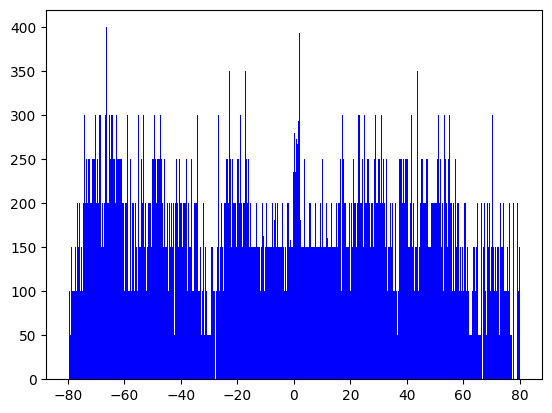

In [89]:
# plot the histogram of unnormalized labels
hist_filename ="histogram_unnormalized_angle_" + str(64) + 'x' + str(64)
num_bins = 500
plt.figure()
plt.hist(labels, num_bins, facecolor='blue', density=False)
plt.savefig(hist_filename)

In [90]:
# normalize labels
print("\n Range of unnormalized labels: ({},{})".format(np.min(labels), np.max(labels)))
min_label_before_shift = np.min(labels)
max_label_after_shift = np.max(labels+np.abs(min_label_before_shift))


 Range of unnormalized labels: (-79.760002,79.97)



 Range of normalized labels: (-0.997000025,0.999625)

 There are 1774 unique labels.

 Use rule-of-thumb formula to compute kernel_sigma >>>

 The std of 89718 labels is 0.5631393524139884 so the kernel sigma is 0.0610022460436445


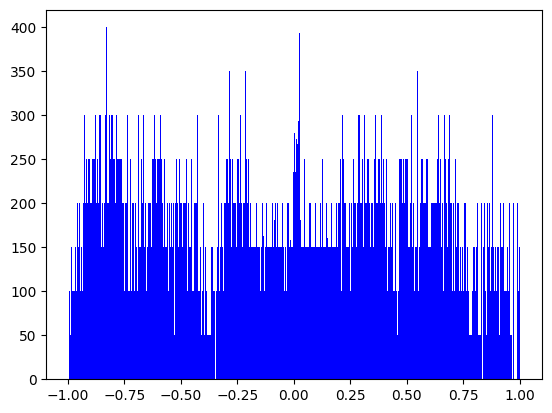

In [91]:

if True:
    # normalize labels to [-1,1]

    labels /= 80
   

    # plot the histogram of normalized labels
    hist_filename = "histogram_normalized_angle_" + str(64) + 'x' + str(64)
    num_bins = 500
    plt.figure()
    plt.hist(labels, num_bins, facecolor='blue', density=False)
    plt.savefig(hist_filename)

    print("\n Range of normalized labels: ({},{})".format(np.min(labels), np.max(labels)))

    unique_labels_norm = np.sort(np.array(list(set(labels))))

    print("\n There are {} unique labels.".format(len(unique_labels_norm)))

    if True:
        std_label = np.std(labels)
        kernel_sigma = 1.06*std_label*(len(labels))**(-1/5)

        print("\n Use rule-of-thumb formula to compute kernel_sigma >>>")
        print("\n The std of {} labels is {} so the kernel sigma is {}".format(len(labels), std_label, kernel_sigma))

    if True:
        n_unique = len(unique_labels_norm)

        diff_list = []
        for i in range(1,n_unique):
            diff_list.append(unique_labels_norm[i] - unique_labels_norm[i-1])
        

## end if args.GAN



In [30]:
batch_size = 659

In [32]:
import tensorflow as tf
# Create tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size)

In [33]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Optimiser for both Generator and Discriminator 
d_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

# Discriminator Loss
def discriminator_loss(real, fake):
    real_loss = tf.reduce_mean(tf.square(tf.ones_like(real) - real))
    fake_loss = tf.reduce_mean(tf.square(tf.zeros_like(fake) - fake))
    total_loss = real_loss + fake_loss
    return total_loss

# Generator Loss
def generator_loss(preds):
    return tf.reduce_mean(tf.square(tf.ones_like(preds) - preds))


In [34]:
import tensorflow as tf

def build_generator(noise_dim=20, image_shape=(64, 64, 3)):
    # Generator input layers
    in_lat = tf.keras.layers.Input(shape=(noise_dim,))
    in_img = tf.keras.layers.Input(shape=image_shape)

    # Fully connected layer for noise
    dense_layer = tf.keras.layers.Dense(256)(in_lat)

    # Reshape noise to match image size
    reshape_layer = tf.keras.layers.Reshape((1, 1, 256))(dense_layer)
    tiled_layer = tf.keras.layers.UpSampling2D(size=(64, 64))(reshape_layer)

    # Convolutional layers with spatial batch normalization and LeakyReLU activations
    conv1 = tf.keras.layers.Conv2D(8, kernel_size=(4, 4), strides=(2, 2), padding='same')(in_img)
    norm1 = tf.keras.layers.BatchNormalization()(conv1)
    leaky_relu1 = tf.keras.layers.LeakyReLU(0.2)(norm1)

    conv2 = tf.keras.layers.Conv2D(16, kernel_size=(4, 4), strides=(2, 2), padding='same')(leaky_relu1)
    norm2 = tf.keras.layers.BatchNormalization()(conv2)
    leaky_relu2 = tf.keras.layers.LeakyReLU(0.2)(norm2)

    conv3 = tf.keras.layers.Conv2D(32, kernel_size=(4, 4), strides=(2, 2), padding='same')(leaky_relu2)
    norm3 = tf.keras.layers.BatchNormalization()(conv3)
    leaky_relu3 = tf.keras.layers.LeakyReLU(0.2)(norm3)

    conv4 = tf.keras.layers.Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same')(leaky_relu3)
    norm4 = tf.keras.layers.BatchNormalization()(conv4)
    leaky_relu4 = tf.keras.layers.LeakyReLU(0.2)(norm4)

    conv5 = tf.keras.layers.Conv2D(128, kernel_size=(4, 4), strides=(2, 2), padding='same')(leaky_relu4)
    norm5 = tf.keras.layers.BatchNormalization()(conv5)
    leaky_relu5 = tf.keras.layers.LeakyReLU(0.2)(norm5)

    conv6 = tf.keras.layers.Conv2D(256, kernel_size=(4, 4), strides=(2, 2), padding='same')(leaky_relu5)
    norm6 = tf.keras.layers.BatchNormalization()(conv6)
    leaky_relu6 = tf.keras.layers.LeakyReLU(0.2)(norm6)

    # Flatten and concatenate with noise
    flatten_layer = tf.keras.layers.Flatten()(leaky_relu6)
    concat_layer2 = tf.keras.layers.Concatenate(axis=-1)([flatten_layer, dense_layer])

    # Fully connected layer
    dense_layer2 = tf.keras.layers.Dense(20)(concat_layer2)

    # Output layer
    output_layer = tf.keras.layers.Dense(1)(dense_layer2)

    # Define the model
    model = tf.keras.models.Model(inputs=[in_lat, in_img], outputs=output_layer)

    return model

# Example usage:
generator = build_generator()


In [35]:
def build_discriminator():
    # Discriminator input layers
    in_img = tf.keras.layers.Input(shape=(64,64,3))
    in_label = tf.keras.layers.Input(shape=(1,))

    # Convolutional layers with spatial batch normalization and LeakyReLU activations
    conv1 = tf.keras.layers.Conv2D(8, kernel_size=(4, 4), strides=(2, 2), padding='same')(in_img)
    norm1 = tf.keras.layers.BatchNormalization()(conv1)
    leaky_relu1 = tf.keras.layers.LeakyReLU(0.2)(norm1)

    conv2 = tf.keras.layers.Conv2D(16, kernel_size=(4, 4), strides=(2, 2), padding='same')(leaky_relu1)
    norm2 = tf.keras.layers.BatchNormalization()(conv2)
    leaky_relu2 = tf.keras.layers.LeakyReLU(0.2)(norm2)

    conv3 = tf.keras.layers.Conv2D(32, kernel_size=(4, 4), strides=(2, 2), padding='same')(leaky_relu2)
    norm3 = tf.keras.layers.BatchNormalization()(conv3)
    leaky_relu3 = tf.keras.layers.LeakyReLU(0.2)(norm3)

    conv4 = tf.keras.layers.Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same')(leaky_relu3)
    norm4 = tf.keras.layers.BatchNormalization()(conv4)
    leaky_relu4 = tf.keras.layers.LeakyReLU(0.2)(norm4)

    conv5 = tf.keras.layers.Conv2D(128, kernel_size=(4, 4), strides=(2, 2), padding='same')(leaky_relu4)
    norm5 = tf.keras.layers.BatchNormalization()(conv5)
    leaky_relu5 = tf.keras.layers.LeakyReLU(0.2)(norm5)

    conv6 = tf.keras.layers.Conv2D(256, kernel_size=(4, 4), strides=(2, 2), padding='same')(leaky_relu5)
    norm6 = tf.keras.layers.BatchNormalization()(conv6)
    leaky_relu6 = tf.keras.layers.LeakyReLU(0.2)(norm6)

    # Flatten
    flatten_layer = tf.keras.layers.Flatten()(leaky_relu6)

    # Concatenate with label
    concat_layer = tf.keras.layers.Concatenate(axis=-1)([flatten_layer, in_label])

    # Fully connected layer
    dense_layer = tf.keras.layers.Dense(1, activation='tanh')(concat_layer)

    # Define the model
    model = tf.keras.models.Model(inputs=[in_img, in_label], outputs=dense_layer)

    return model

discriminator = build_discriminator()


In [36]:
noise_dim = 20
# Compiles the train_step function into a callable TensorFlow graph
@tf.function
def train_step(dataset):
	

	real_images1, real_labels1 = dataset
	real_images1 = tf.reshape(real_images1, (-1,64, 64, 3))
	# Sample random points in the latent space and concatenate the labels.
	random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim))
	generated_labels = generator([random_latent_vectors, real_images1])

	# Train the discriminator.
	with tf.GradientTape() as tape:
		pred_fake = discriminator([real_images1, generated_labels])
		pred_real = discriminator([real_images1, real_labels1])
		
		d_loss = discriminator_loss(pred_real, pred_fake)
		print(d_loss)

	grads = tape.gradient(d_loss, discriminator.trainable_variables)

	# print(grads)
	d_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

	#-----------------------------------------------------------------#
	
	# Sample random points in the latent space.
	random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim))
	
	# Train the generator
	with tf.GradientTape() as tape:
		fake_labels = generator([random_latent_vectors, real_images1])

		predictions = discriminator([real_images1,fake_labels])

		g_loss = generator_loss(predictions)
	
	grads = tape.gradient(g_loss, generator.trainable_variables)

	g_optimizer.apply_gradients(zip(grads, generator.trainable_variables))
	
	return d_loss, g_loss


In [38]:
from tqdm import tqdm

import time

if True:
	d = []
	g = []
	for epoch in range(200):
		print('Epoch: ', epoch)
		d_loss_list = []
		g_loss_list = []
		q_loss_list = []
		start = time.time()
		itern = 0
		for image_batch in tqdm(dataset):
		# 	real_images1, real_labels1 = image_batch

		# print(real_images1.shape)

			d_loss, g_loss = train_step(image_batch)

			d_loss_list.append(d_loss)
			g_loss_list.append(g_loss)

			itern=itern+1
			#print(d_loss_list)
		d_loss_list_mean = tf.reduce_mean(tf.stack(d_loss_list))
		g_loss_list_mean = tf.reduce_mean(tf.stack(g_loss_list))
		d.append(d_loss_list_mean)
		g.append(g_loss_list_mean)
		print (f'Epoch: {epoch} -- Generator Loss: {g_loss_list_mean}, Discriminator Loss: {d_loss_list_mean}\n')
		print (f'Took {time.time()-start} seconds. \n\n')
		




Epoch:  0


  0%|          | 0/21 [00:00<?, ?it/s]

Tensor("add:0", shape=(), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)


100%|██████████| 21/21 [01:00<00:00,  2.89s/it]


Epoch: 0 -- Generator Loss: 0.23287633061408997, Discriminator Loss: 0.800065815448761

Took 61.36494588851929 seconds. 


Epoch:  1


100%|██████████| 21/21 [01:21<00:00,  3.90s/it]


Epoch: 1 -- Generator Loss: 0.0003780923434533179, Discriminator Loss: 0.986983060836792

Took 82.02948117256165 seconds. 


Epoch:  2


100%|██████████| 21/21 [00:46<00:00,  2.21s/it]


Epoch: 2 -- Generator Loss: 0.00022143493697512895, Discriminator Loss: 0.990715742111206

Took 46.365914821624756 seconds. 


Epoch:  3


100%|██████████| 21/21 [00:48<00:00,  2.33s/it]


Epoch: 3 -- Generator Loss: 0.00014804063539486378, Discriminator Loss: 0.9927780628204346

Took 49.039855003356934 seconds. 


Epoch:  4


100%|██████████| 21/21 [00:48<00:00,  2.32s/it]


Epoch: 4 -- Generator Loss: 0.00010925789683824405, Discriminator Loss: 0.9940420985221863

Took 48.74070119857788 seconds. 


Epoch:  5


100%|██████████| 21/21 [00:43<00:00,  2.06s/it]


Epoch: 5 -- Generator Loss: 8.770303975325078e-05, Discriminator Loss: 0.9948473572731018

Took 43.24610900878906 seconds. 


Epoch:  6


100%|██████████| 21/21 [00:46<00:00,  2.21s/it]


Epoch: 6 -- Generator Loss: 7.231944618979469e-05, Discriminator Loss: 0.9954240918159485

Took 46.35851287841797 seconds. 


Epoch:  7


100%|██████████| 21/21 [00:45<00:00,  2.18s/it]


Epoch: 7 -- Generator Loss: 6.373578798957169e-05, Discriminator Loss: 0.9958463311195374

Took 45.76588582992554 seconds. 


Epoch:  8


100%|██████████| 21/21 [00:46<00:00,  2.19s/it]


Epoch: 8 -- Generator Loss: 5.6624325225129724e-05, Discriminator Loss: 0.9961263537406921

Took 46.050616979599 seconds. 


Epoch:  9


100%|██████████| 21/21 [00:46<00:00,  2.22s/it]


Epoch: 9 -- Generator Loss: 5.2782317652599886e-05, Discriminator Loss: 0.9963350892066956

Took 46.73694610595703 seconds. 


Epoch:  10


100%|██████████| 21/21 [00:42<00:00,  2.00s/it]


Epoch: 10 -- Generator Loss: 4.9268786824541166e-05, Discriminator Loss: 0.996477484703064

Took 42.072383880615234 seconds. 


Epoch:  11


100%|██████████| 21/21 [00:45<00:00,  2.15s/it]


Epoch: 11 -- Generator Loss: 4.768483995576389e-05, Discriminator Loss: 0.9965329170227051

Took 45.19039702415466 seconds. 


Epoch:  12


100%|██████████| 21/21 [00:44<00:00,  2.11s/it]


Epoch: 12 -- Generator Loss: 4.8148805944947526e-05, Discriminator Loss: 0.996524453163147

Took 44.40314698219299 seconds. 


Epoch:  13


100%|██████████| 21/21 [00:28<00:00,  1.35s/it]


Epoch: 13 -- Generator Loss: 5.0103364628739655e-05, Discriminator Loss: 0.9964492321014404

Took 28.2877299785614 seconds. 


Epoch:  14


100%|██████████| 21/21 [00:20<00:00,  1.04it/s]


Epoch: 14 -- Generator Loss: 5.4026015277486295e-05, Discriminator Loss: 0.9962297081947327

Took 20.26138710975647 seconds. 


Epoch:  15


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Epoch: 15 -- Generator Loss: 6.323384877759963e-05, Discriminator Loss: 0.9958291053771973

Took 18.990812063217163 seconds. 


Epoch:  16


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Epoch: 16 -- Generator Loss: 8.355871250387281e-05, Discriminator Loss: 0.9949954748153687

Took 19.540925979614258 seconds. 


Epoch:  17


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Epoch: 17 -- Generator Loss: 0.00015149648243095726, Discriminator Loss: 0.992870032787323

Took 19.563361883163452 seconds. 


Epoch:  18


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Epoch: 18 -- Generator Loss: 0.05513346940279007, Discriminator Loss: 0.9431450963020325

Took 18.991276025772095 seconds. 


Epoch:  19


100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


Epoch: 19 -- Generator Loss: 0.2481057345867157, Discriminator Loss: 0.5770042538642883

Took 19.60220503807068 seconds. 


Epoch:  20


100%|██████████| 21/21 [00:20<00:00,  1.01it/s]


Epoch: 20 -- Generator Loss: 0.29749831557273865, Discriminator Loss: 0.48883628845214844

Took 20.867770195007324 seconds. 


Epoch:  21


100%|██████████| 21/21 [00:18<00:00,  1.14it/s]


Epoch: 21 -- Generator Loss: 0.2439763844013214, Discriminator Loss: 0.6195216178894043

Took 18.448582887649536 seconds. 


Epoch:  22


100%|██████████| 21/21 [00:19<00:00,  1.06it/s]


Epoch: 22 -- Generator Loss: 0.2734723687171936, Discriminator Loss: 0.5352959632873535

Took 19.889635801315308 seconds. 


Epoch:  23


100%|██████████| 21/21 [00:20<00:00,  1.04it/s]


Epoch: 23 -- Generator Loss: 0.24592144787311554, Discriminator Loss: 0.5090727210044861

Took 20.2340350151062 seconds. 


Epoch:  24


100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


Epoch: 24 -- Generator Loss: 0.21128277480602264, Discriminator Loss: 0.5574859380722046

Took 19.62496519088745 seconds. 


Epoch:  25


100%|██████████| 21/21 [00:21<00:00,  1.00s/it]


Epoch: 25 -- Generator Loss: 0.29871559143066406, Discriminator Loss: 0.4659288823604584

Took 21.067169666290283 seconds. 


Epoch:  26


100%|██████████| 21/21 [00:21<00:00,  1.03s/it]


Epoch: 26 -- Generator Loss: 0.25659823417663574, Discriminator Loss: 0.4934210479259491

Took 21.6561758518219 seconds. 


Epoch:  27


100%|██████████| 21/21 [00:22<00:00,  1.06s/it]


Epoch: 27 -- Generator Loss: 0.22547324001789093, Discriminator Loss: 0.5334239602088928

Took 22.289743185043335 seconds. 


Epoch:  28


100%|██████████| 21/21 [00:24<00:00,  1.16s/it]


Epoch: 28 -- Generator Loss: 0.2880323529243469, Discriminator Loss: 0.523011326789856

Took 24.377184867858887 seconds. 


Epoch:  29


100%|██████████| 21/21 [00:24<00:00,  1.18s/it]


Epoch: 29 -- Generator Loss: 0.2530338764190674, Discriminator Loss: 0.49901634454727173

Took 24.745598077774048 seconds. 


Epoch:  30


100%|██████████| 21/21 [00:23<00:00,  1.11s/it]


Epoch: 30 -- Generator Loss: 0.2486030012369156, Discriminator Loss: 0.5035161375999451

Took 23.27001190185547 seconds. 


Epoch:  31


100%|██████████| 21/21 [00:23<00:00,  1.12s/it]


Epoch: 31 -- Generator Loss: 0.23045912384986877, Discriminator Loss: 0.5264419913291931

Took 23.50294518470764 seconds. 


Epoch:  32


100%|██████████| 21/21 [00:22<00:00,  1.09s/it]


Epoch: 32 -- Generator Loss: 0.28196820616722107, Discriminator Loss: 0.5114971995353699

Took 22.846107006072998 seconds. 


Epoch:  33


100%|██████████| 21/21 [00:23<00:00,  1.14s/it]


Epoch: 33 -- Generator Loss: 0.25702574849128723, Discriminator Loss: 0.4926741123199463

Took 23.946409940719604 seconds. 


Epoch:  34


100%|██████████| 21/21 [00:23<00:00,  1.11s/it]


Epoch: 34 -- Generator Loss: 0.22532036900520325, Discriminator Loss: 0.5327210426330566

Took 23.291526079177856 seconds. 


Epoch:  35


100%|██████████| 21/21 [00:22<00:00,  1.08s/it]


Epoch: 35 -- Generator Loss: 0.27147340774536133, Discriminator Loss: 0.524186909198761

Took 22.659663200378418 seconds. 


Epoch:  36


100%|██████████| 21/21 [00:24<00:00,  1.18s/it]


Epoch: 36 -- Generator Loss: 0.25554269552230835, Discriminator Loss: 0.49404802918434143

Took 24.804597854614258 seconds. 


Epoch:  37


100%|██████████| 21/21 [00:24<00:00,  1.16s/it]


Epoch: 37 -- Generator Loss: 0.25004157423973083, Discriminator Loss: 0.5004933476448059

Took 24.378552675247192 seconds. 


Epoch:  38


100%|██████████| 21/21 [00:24<00:00,  1.19s/it]


Epoch: 38 -- Generator Loss: 0.24782396852970123, Discriminator Loss: 0.5030332207679749

Took 24.900745153427124 seconds. 


Epoch:  39


100%|██████████| 21/21 [00:22<00:00,  1.09s/it]


Epoch: 39 -- Generator Loss: 0.24445755779743195, Discriminator Loss: 0.5070975422859192

Took 22.863775968551636 seconds. 


Epoch:  40


100%|██████████| 21/21 [00:23<00:00,  1.10s/it]


Epoch: 40 -- Generator Loss: 0.23413220047950745, Discriminator Loss: 0.5201081037521362

Took 23.112984895706177 seconds. 


Epoch:  41


100%|██████████| 21/21 [00:23<00:00,  1.12s/it]


Epoch: 41 -- Generator Loss: 0.23643289506435394, Discriminator Loss: 0.5284935235977173

Took 23.602314949035645 seconds. 


Epoch:  42


100%|██████████| 21/21 [00:26<00:00,  1.26s/it]


Epoch: 42 -- Generator Loss: 0.2777981162071228, Discriminator Loss: 0.4703575372695923

Took 26.586066961288452 seconds. 


Epoch:  43


100%|██████████| 21/21 [00:23<00:00,  1.12s/it]


Epoch: 43 -- Generator Loss: 0.2572250962257385, Discriminator Loss: 0.49184346199035645

Took 23.47997498512268 seconds. 


Epoch:  44


100%|██████████| 21/21 [00:23<00:00,  1.14s/it]


Epoch: 44 -- Generator Loss: 0.2530214190483093, Discriminator Loss: 0.496620774269104

Took 23.968921184539795 seconds. 


Epoch:  45


100%|██████████| 21/21 [00:23<00:00,  1.12s/it]


Epoch: 45 -- Generator Loss: 0.24447154998779297, Discriminator Loss: 0.507287859916687

Took 23.581480979919434 seconds. 


Epoch:  46


100%|██████████| 21/21 [00:24<00:00,  1.15s/it]


Epoch: 46 -- Generator Loss: 0.26227718591690063, Discriminator Loss: 0.5578473210334778

Took 24.11939811706543 seconds. 


Epoch:  47


100%|██████████| 21/21 [00:23<00:00,  1.14s/it]


Epoch: 47 -- Generator Loss: 0.19969967007637024, Discriminator Loss: 0.5774558782577515

Took 24.005908966064453 seconds. 


Epoch:  48


100%|██████████| 21/21 [00:24<00:00,  1.15s/it]


Epoch: 48 -- Generator Loss: 0.30604976415634155, Discriminator Loss: 0.47332096099853516

Took 24.069947957992554 seconds. 


Epoch:  49


100%|██████████| 21/21 [00:24<00:00,  1.16s/it]


Epoch: 49 -- Generator Loss: 0.2510485053062439, Discriminator Loss: 0.49910664558410645

Took 24.44236183166504 seconds. 


Epoch:  50


100%|██████████| 21/21 [00:24<00:00,  1.18s/it]


Epoch: 50 -- Generator Loss: 0.24149581789970398, Discriminator Loss: 0.5107097029685974

Took 24.804003715515137 seconds. 


Epoch:  51


100%|██████████| 21/21 [00:24<00:00,  1.15s/it]


Epoch: 51 -- Generator Loss: 0.21430058777332306, Discriminator Loss: 0.5584965944290161

Took 24.090121030807495 seconds. 


Epoch:  52


100%|██████████| 21/21 [00:25<00:00,  1.21s/it]


Epoch: 52 -- Generator Loss: 0.29020190238952637, Discriminator Loss: 0.4638609290122986

Took 25.404985189437866 seconds. 


Epoch:  53


100%|██████████| 21/21 [00:24<00:00,  1.18s/it]


Epoch: 53 -- Generator Loss: 0.25482040643692017, Discriminator Loss: 0.49451908469200134

Took 24.814038038253784 seconds. 


Epoch:  54


100%|██████████| 21/21 [00:27<00:00,  1.30s/it]


Epoch: 54 -- Generator Loss: 0.2499370276927948, Discriminator Loss: 0.5002859830856323

Took 27.35194230079651 seconds. 


Epoch:  55


100%|██████████| 21/21 [00:24<00:00,  1.19s/it]


Epoch: 55 -- Generator Loss: 0.2450983226299286, Discriminator Loss: 0.5061550140380859

Took 25.012516260147095 seconds. 


Epoch:  56


100%|██████████| 21/21 [00:24<00:00,  1.17s/it]


Epoch: 56 -- Generator Loss: 0.22031791508197784, Discriminator Loss: 0.5392916798591614

Took 24.660027265548706 seconds. 


Epoch:  57


100%|██████████| 21/21 [00:26<00:00,  1.28s/it]


Epoch: 57 -- Generator Loss: 0.2791815996170044, Discriminator Loss: 0.48986974358558655

Took 26.923996925354004 seconds. 


Epoch:  58


100%|██████████| 21/21 [00:23<00:00,  1.14s/it]


Epoch: 58 -- Generator Loss: 0.25550326704978943, Discriminator Loss: 0.4936532974243164

Took 23.90245795249939 seconds. 


Epoch:  59


100%|██████████| 21/21 [00:24<00:00,  1.16s/it]


Epoch: 59 -- Generator Loss: 0.25160661339759827, Discriminator Loss: 0.4982452988624573

Took 24.37951111793518 seconds. 


Epoch:  60


100%|██████████| 21/21 [00:22<00:00,  1.09s/it]


Epoch: 60 -- Generator Loss: 0.2487899512052536, Discriminator Loss: 0.501596987247467

Took 22.893118381500244 seconds. 


Epoch:  61


100%|██████████| 21/21 [00:24<00:00,  1.15s/it]


Epoch: 61 -- Generator Loss: 0.24241498112678528, Discriminator Loss: 0.5094313025474548

Took 24.09332799911499 seconds. 


Epoch:  62


100%|██████████| 21/21 [00:23<00:00,  1.12s/it]


Epoch: 62 -- Generator Loss: 0.24332892894744873, Discriminator Loss: 0.5360282063484192

Took 23.47713589668274 seconds. 


Epoch:  63


100%|██████████| 21/21 [00:23<00:00,  1.14s/it]


Epoch: 63 -- Generator Loss: 0.2667505443096161, Discriminator Loss: 0.4821845591068268

Took 23.949156999588013 seconds. 


Epoch:  64


100%|██████████| 21/21 [00:23<00:00,  1.12s/it]


Epoch: 64 -- Generator Loss: 0.23992933332920074, Discriminator Loss: 0.5127561092376709

Took 23.558050632476807 seconds. 


Epoch:  65


100%|██████████| 21/21 [00:24<00:00,  1.17s/it]


Epoch: 65 -- Generator Loss: 0.2523120641708374, Discriminator Loss: 0.525336503982544

Took 24.50189518928528 seconds. 


Epoch:  66


100%|██████████| 21/21 [00:25<00:00,  1.23s/it]


Epoch: 66 -- Generator Loss: 0.2611970007419586, Discriminator Loss: 0.4873390793800354

Took 25.850666999816895 seconds. 


Epoch:  67


100%|██████████| 21/21 [00:25<00:00,  1.20s/it]


Epoch: 67 -- Generator Loss: 0.2501756250858307, Discriminator Loss: 0.4999552369117737

Took 25.151105165481567 seconds. 


Epoch:  68


100%|██████████| 21/21 [00:24<00:00,  1.18s/it]


Epoch: 68 -- Generator Loss: 0.24001744389533997, Discriminator Loss: 0.5125023722648621

Took 24.720590114593506 seconds. 


Epoch:  69


100%|██████████| 21/21 [00:25<00:00,  1.20s/it]


Epoch: 69 -- Generator Loss: 0.24183174967765808, Discriminator Loss: 0.5321837663650513

Took 25.117693185806274 seconds. 


Epoch:  70


100%|██████████| 21/21 [00:25<00:00,  1.21s/it]


Epoch: 70 -- Generator Loss: 0.26951172947883606, Discriminator Loss: 0.47891488671302795

Took 25.473706007003784 seconds. 


Epoch:  71


100%|██████████| 21/21 [00:24<00:00,  1.17s/it]


Epoch: 71 -- Generator Loss: 0.25282275676727295, Discriminator Loss: 0.49672040343284607

Took 24.55041217803955 seconds. 


Epoch:  72


100%|██████████| 21/21 [00:23<00:00,  1.11s/it]


Epoch: 72 -- Generator Loss: 0.25029245018959045, Discriminator Loss: 0.4997233748435974

Took 23.369739055633545 seconds. 


Epoch:  73


100%|██████████| 21/21 [00:24<00:00,  1.18s/it]


Epoch: 73 -- Generator Loss: 0.24909250438213348, Discriminator Loss: 0.5011262893676758

Took 24.710747718811035 seconds. 


Epoch:  74


100%|██████████| 21/21 [00:24<00:00,  1.16s/it]


Epoch: 74 -- Generator Loss: 0.2477674037218094, Discriminator Loss: 0.5027403235435486

Took 24.319112062454224 seconds. 


Epoch:  75


100%|██████████| 21/21 [00:24<00:00,  1.16s/it]


Epoch: 75 -- Generator Loss: 0.2435246706008911, Discriminator Loss: 0.5079855918884277

Took 24.454642295837402 seconds. 


Epoch:  76


100%|██████████| 21/21 [00:23<00:00,  1.10s/it]


Epoch: 76 -- Generator Loss: 0.2198529988527298, Discriminator Loss: 0.5487948060035706

Took 23.200880765914917 seconds. 


Epoch:  77


100%|██████████| 21/21 [00:24<00:00,  1.19s/it]


Epoch: 77 -- Generator Loss: 0.2870240807533264, Discriminator Loss: 0.4697832465171814

Took 24.904277086257935 seconds. 


Epoch:  78


100%|██████████| 21/21 [00:23<00:00,  1.13s/it]


Epoch: 78 -- Generator Loss: 0.2538803219795227, Discriminator Loss: 0.4955647885799408

Took 23.71141290664673 seconds. 


Epoch:  79


100%|██████████| 21/21 [00:26<00:00,  1.24s/it]


Epoch: 79 -- Generator Loss: 0.2510271668434143, Discriminator Loss: 0.4988292455673218

Took 26.09842872619629 seconds. 


Epoch:  80


100%|██████████| 21/21 [00:25<00:00,  1.20s/it]


Epoch: 80 -- Generator Loss: 0.2491753250360489, Discriminator Loss: 0.5011034607887268

Took 25.147329092025757 seconds. 


Epoch:  81


100%|██████████| 21/21 [00:24<00:00,  1.19s/it]


Epoch: 81 -- Generator Loss: 0.24228322505950928, Discriminator Loss: 0.5095841288566589

Took 24.914781093597412 seconds. 


Epoch:  82


100%|██████████| 21/21 [00:24<00:00,  1.15s/it]


Epoch: 82 -- Generator Loss: 0.24947039783000946, Discriminator Loss: 0.5306761860847473

Took 24.154783964157104 seconds. 


Epoch:  83


100%|██████████| 21/21 [00:23<00:00,  1.13s/it]


Epoch: 83 -- Generator Loss: 0.2606467604637146, Discriminator Loss: 0.4880269765853882

Took 23.773852348327637 seconds. 


Epoch:  84


100%|██████████| 21/21 [00:23<00:00,  1.14s/it]


Epoch: 84 -- Generator Loss: 0.25150349736213684, Discriminator Loss: 0.4982880651950836

Took 23.845552682876587 seconds. 


Epoch:  85


100%|██████████| 21/21 [00:24<00:00,  1.16s/it]


Epoch: 85 -- Generator Loss: 0.24998365342617035, Discriminator Loss: 0.5000947117805481

Took 24.442126989364624 seconds. 


Epoch:  86


100%|██████████| 21/21 [00:24<00:00,  1.16s/it]


Epoch: 86 -- Generator Loss: 0.24921919405460358, Discriminator Loss: 0.5009776949882507

Took 24.359609842300415 seconds. 


Epoch:  87


100%|██████████| 21/21 [00:24<00:00,  1.16s/it]


Epoch: 87 -- Generator Loss: 0.24846631288528442, Discriminator Loss: 0.5019219517707825

Took 24.280256032943726 seconds. 


Epoch:  88


100%|██████████| 21/21 [00:26<00:00,  1.24s/it]


Epoch: 88 -- Generator Loss: 0.24708223342895508, Discriminator Loss: 0.5035535097122192

Took 26.068081378936768 seconds. 


Epoch:  89


100%|██████████| 21/21 [00:24<00:00,  1.17s/it]


Epoch: 89 -- Generator Loss: 0.2436772584915161, Discriminator Loss: 0.5078177452087402

Took 24.656485080718994 seconds. 


Epoch:  90


100%|██████████| 21/21 [00:25<00:00,  1.20s/it]


Epoch: 90 -- Generator Loss: 0.22598284482955933, Discriminator Loss: 0.5321370959281921

Took 25.22520613670349 seconds. 


Epoch:  91


100%|██████████| 21/21 [00:24<00:00,  1.18s/it]


Epoch: 91 -- Generator Loss: 0.2759346663951874, Discriminator Loss: 0.4811885356903076

Took 24.8895161151886 seconds. 


Epoch:  92


100%|██████████| 21/21 [00:24<00:00,  1.18s/it]


Epoch: 92 -- Generator Loss: 0.2564321458339691, Discriminator Loss: 0.4924759268760681

Took 24.821008920669556 seconds. 


Epoch:  93


100%|██████████| 21/21 [00:24<00:00,  1.17s/it]


Epoch: 93 -- Generator Loss: 0.2529503405094147, Discriminator Loss: 0.496561735868454

Took 24.68769121170044 seconds. 


Epoch:  94


100%|██████████| 21/21 [00:24<00:00,  1.16s/it]


Epoch: 94 -- Generator Loss: 0.2516305148601532, Discriminator Loss: 0.4980993866920471

Took 24.374070167541504 seconds. 


Epoch:  95


100%|██████████| 21/21 [00:27<00:00,  1.31s/it]


Epoch: 95 -- Generator Loss: 0.25089845061302185, Discriminator Loss: 0.498963862657547

Took 27.62568497657776 seconds. 


Epoch:  96


100%|██████████| 21/21 [00:25<00:00,  1.23s/it]


Epoch: 96 -- Generator Loss: 0.25032535195350647, Discriminator Loss: 0.49965086579322815

Took 25.82954978942871 seconds. 


Epoch:  97


100%|██████████| 21/21 [00:25<00:00,  1.20s/it]


Epoch: 97 -- Generator Loss: 0.24957644939422607, Discriminator Loss: 0.5004975199699402

Took 25.193175077438354 seconds. 


Epoch:  98


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch: 98 -- Generator Loss: 0.24775707721710205, Discriminator Loss: 0.5028344392776489

Took 25.720000982284546 seconds. 


Epoch:  99


100%|██████████| 21/21 [00:24<00:00,  1.19s/it]


Epoch: 99 -- Generator Loss: 0.237280935049057, Discriminator Loss: 0.5159440040588379

Took 24.919153213500977 seconds. 


Epoch:  100


100%|██████████| 21/21 [00:25<00:00,  1.20s/it]


Epoch: 100 -- Generator Loss: 0.2612002491950989, Discriminator Loss: 0.5127879977226257

Took 25.136950969696045 seconds. 


Epoch:  101


100%|██████████| 21/21 [00:24<00:00,  1.15s/it]


Epoch: 101 -- Generator Loss: 0.2578202486038208, Discriminator Loss: 0.4913320541381836

Took 24.253183126449585 seconds. 


Epoch:  102


100%|██████████| 21/21 [00:24<00:00,  1.19s/it]


Epoch: 102 -- Generator Loss: 0.25142702460289, Discriminator Loss: 0.4984128177165985

Took 24.962531089782715 seconds. 


Epoch:  103


100%|██████████| 21/21 [00:25<00:00,  1.20s/it]


Epoch: 103 -- Generator Loss: 0.2502206265926361, Discriminator Loss: 0.4997859597206116

Took 25.16928195953369 seconds. 


Epoch:  104


100%|██████████| 21/21 [00:24<00:00,  1.15s/it]


Epoch: 104 -- Generator Loss: 0.24977119266986847, Discriminator Loss: 0.5003048777580261

Took 24.269799947738647 seconds. 


Epoch:  105


100%|██████████| 21/21 [00:25<00:00,  1.20s/it]


Epoch: 105 -- Generator Loss: 0.2494359314441681, Discriminator Loss: 0.5007506012916565

Took 25.28336811065674 seconds. 


Epoch:  106


100%|██████████| 21/21 [00:25<00:00,  1.23s/it]


Epoch: 106 -- Generator Loss: 0.24904057383537292, Discriminator Loss: 0.5012091398239136

Took 25.746408224105835 seconds. 


Epoch:  107


100%|██████████| 21/21 [00:25<00:00,  1.21s/it]


Epoch: 107 -- Generator Loss: 0.24852587282657623, Discriminator Loss: 0.5017837882041931

Took 25.511410236358643 seconds. 


Epoch:  108


100%|██████████| 21/21 [00:26<00:00,  1.24s/it]


Epoch: 108 -- Generator Loss: 0.2478991448879242, Discriminator Loss: 0.5025862455368042

Took 26.14224410057068 seconds. 


Epoch:  109


100%|██████████| 21/21 [00:24<00:00,  1.15s/it]


Epoch: 109 -- Generator Loss: 0.24707208573818207, Discriminator Loss: 0.5036259293556213

Took 24.171898126602173 seconds. 


Epoch:  110


100%|██████████| 21/21 [00:25<00:00,  1.20s/it]


Epoch: 110 -- Generator Loss: 0.24599114060401917, Discriminator Loss: 0.5049545168876648

Took 25.167309999465942 seconds. 


Epoch:  111


100%|██████████| 21/21 [00:24<00:00,  1.15s/it]


Epoch: 111 -- Generator Loss: 0.2446925938129425, Discriminator Loss: 0.5065257549285889

Took 24.25785803794861 seconds. 


Epoch:  112


100%|██████████| 21/21 [00:24<00:00,  1.17s/it]


Epoch: 112 -- Generator Loss: 0.24303670227527618, Discriminator Loss: 0.5085856318473816

Took 24.592586994171143 seconds. 


Epoch:  113


100%|██████████| 21/21 [00:24<00:00,  1.15s/it]


Epoch: 113 -- Generator Loss: 0.23999302089214325, Discriminator Loss: 0.5130006074905396

Took 24.059192657470703 seconds. 


Epoch:  114


100%|██████████| 21/21 [00:24<00:00,  1.14s/it]


Epoch: 114 -- Generator Loss: 0.25918737053871155, Discriminator Loss: 0.49204209446907043

Took 24.041449069976807 seconds. 


Epoch:  115


100%|██████████| 21/21 [00:27<00:00,  1.30s/it]


Epoch: 115 -- Generator Loss: 0.25819551944732666, Discriminator Loss: 0.4905052185058594

Took 27.277194023132324 seconds. 


Epoch:  116


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch: 116 -- Generator Loss: 0.25593122839927673, Discriminator Loss: 0.49305930733680725

Took 25.52780294418335 seconds. 


Epoch:  117


100%|██████████| 21/21 [00:24<00:00,  1.18s/it]


Epoch: 117 -- Generator Loss: 0.2542959749698639, Discriminator Loss: 0.4948829412460327

Took 24.83705997467041 seconds. 


Epoch:  118


100%|██████████| 21/21 [00:26<00:00,  1.24s/it]


Epoch: 118 -- Generator Loss: 0.25274407863616943, Discriminator Loss: 0.4967576861381531

Took 26.025075912475586 seconds. 


Epoch:  119


100%|██████████| 21/21 [00:24<00:00,  1.19s/it]


Epoch: 119 -- Generator Loss: 0.24938049912452698, Discriminator Loss: 0.5008652806282043

Took 24.9488468170166 seconds. 


Epoch:  120


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch: 120 -- Generator Loss: 0.24948935210704803, Discriminator Loss: 0.5443815588951111

Took 25.615993976593018 seconds. 


Epoch:  121


100%|██████████| 21/21 [00:27<00:00,  1.30s/it]


Epoch: 121 -- Generator Loss: 0.26311278343200684, Discriminator Loss: 0.4865282475948334

Took 27.28589105606079 seconds. 


Epoch:  122


100%|██████████| 21/21 [00:24<00:00,  1.18s/it]


Epoch: 122 -- Generator Loss: 0.24880702793598175, Discriminator Loss: 0.501552939414978

Took 24.77905511856079 seconds. 


Epoch:  123


100%|██████████| 21/21 [00:24<00:00,  1.16s/it]


Epoch: 123 -- Generator Loss: 0.24650219082832336, Discriminator Loss: 0.5042492747306824

Took 24.273327112197876 seconds. 


Epoch:  124


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch: 124 -- Generator Loss: 0.2453250139951706, Discriminator Loss: 0.5057053565979004

Took 25.64996099472046 seconds. 


Epoch:  125


100%|██████████| 21/21 [00:23<00:00,  1.10s/it]


Epoch: 125 -- Generator Loss: 0.24428987503051758, Discriminator Loss: 0.5069853663444519

Took 23.225056886672974 seconds. 


Epoch:  126


100%|██████████| 21/21 [00:24<00:00,  1.14s/it]


Epoch: 126 -- Generator Loss: 0.24365320801734924, Discriminator Loss: 0.507797360420227

Took 24.017701148986816 seconds. 


Epoch:  127


100%|██████████| 21/21 [00:22<00:00,  1.09s/it]


Epoch: 127 -- Generator Loss: 0.2436327487230301, Discriminator Loss: 0.5077782869338989

Took 22.899134874343872 seconds. 


Epoch:  128


100%|██████████| 21/21 [00:23<00:00,  1.11s/it]


Epoch: 128 -- Generator Loss: 0.24474570155143738, Discriminator Loss: 0.5064756870269775

Took 23.287240982055664 seconds. 


Epoch:  129


100%|██████████| 21/21 [00:21<00:00,  1.01s/it]


Epoch: 129 -- Generator Loss: 0.24709370732307434, Discriminator Loss: 0.503710150718689

Took 21.2972469329834 seconds. 


Epoch:  130


100%|██████████| 21/21 [00:21<00:00,  1.03s/it]


Epoch: 130 -- Generator Loss: 0.2503395676612854, Discriminator Loss: 0.4998273253440857

Took 21.707794904708862 seconds. 


Epoch:  131


100%|██████████| 21/21 [00:23<00:00,  1.11s/it]


Epoch: 131 -- Generator Loss: 0.2535535991191864, Discriminator Loss: 0.4959664046764374

Took 23.348591089248657 seconds. 


Epoch:  132


100%|██████████| 21/21 [00:23<00:00,  1.11s/it]


Epoch: 132 -- Generator Loss: 0.2557941675186157, Discriminator Loss: 0.4932100772857666

Took 23.38191795349121 seconds. 


Epoch:  133


100%|██████████| 21/21 [00:23<00:00,  1.13s/it]


Epoch: 133 -- Generator Loss: 0.25676578283309937, Discriminator Loss: 0.4920649230480194

Took 23.690077781677246 seconds. 


Epoch:  134


100%|██████████| 21/21 [00:24<00:00,  1.19s/it]


Epoch: 134 -- Generator Loss: 0.25654903054237366, Discriminator Loss: 0.4922618269920349

Took 24.97382092475891 seconds. 


Epoch:  135


100%|██████████| 21/21 [00:24<00:00,  1.19s/it]


Epoch: 135 -- Generator Loss: 0.2557453513145447, Discriminator Loss: 0.4932122826576233

Took 25.01632571220398 seconds. 


Epoch:  136


100%|██████████| 21/21 [00:24<00:00,  1.14s/it]


Epoch: 136 -- Generator Loss: 0.25459542870521545, Discriminator Loss: 0.4945671856403351

Took 24.04502582550049 seconds. 


Epoch:  137


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch: 137 -- Generator Loss: 0.25312620401382446, Discriminator Loss: 0.49628058075904846

Took 25.729331970214844 seconds. 


Epoch:  138


100%|██████████| 21/21 [00:24<00:00,  1.19s/it]


Epoch: 138 -- Generator Loss: 0.24967683851718903, Discriminator Loss: 0.5005289912223816

Took 25.005286931991577 seconds. 


Epoch:  139


100%|██████████| 21/21 [00:24<00:00,  1.19s/it]


Epoch: 139 -- Generator Loss: 0.2306511253118515, Discriminator Loss: 0.524882435798645

Took 24.979025840759277 seconds. 


Epoch:  140


100%|██████████| 21/21 [00:28<00:00,  1.34s/it]


Epoch: 140 -- Generator Loss: 0.270286500453949, Discriminator Loss: 0.5021942257881165

Took 28.087019205093384 seconds. 


Epoch:  141


100%|██████████| 21/21 [00:25<00:00,  1.20s/it]


Epoch: 141 -- Generator Loss: 0.2538352906703949, Discriminator Loss: 0.4955533444881439

Took 25.24160408973694 seconds. 


Epoch:  142


100%|██████████| 21/21 [00:26<00:00,  1.27s/it]


Epoch: 142 -- Generator Loss: 0.24847957491874695, Discriminator Loss: 0.5018699765205383

Took 26.639235258102417 seconds. 


Epoch:  143


100%|██████████| 21/21 [00:25<00:00,  1.20s/it]


Epoch: 143 -- Generator Loss: 0.24626055359840393, Discriminator Loss: 0.5046167969703674

Took 25.154350757598877 seconds. 


Epoch:  144


100%|██████████| 21/21 [00:23<00:00,  1.12s/it]


Epoch: 144 -- Generator Loss: 0.24470919370651245, Discriminator Loss: 0.5064438581466675

Took 23.46441888809204 seconds. 


Epoch:  145


100%|██████████| 21/21 [00:24<00:00,  1.18s/it]


Epoch: 145 -- Generator Loss: 0.24359893798828125, Discriminator Loss: 0.5078102350234985

Took 24.780592918395996 seconds. 


Epoch:  146


100%|██████████| 21/21 [00:24<00:00,  1.17s/it]


Epoch: 146 -- Generator Loss: 0.24306505918502808, Discriminator Loss: 0.5084927678108215

Took 24.48109793663025 seconds. 


Epoch:  147


100%|██████████| 21/21 [00:23<00:00,  1.12s/it]


Epoch: 147 -- Generator Loss: 0.24347226321697235, Discriminator Loss: 0.5080393552780151

Took 23.650291204452515 seconds. 


Epoch:  148


100%|██████████| 21/21 [00:23<00:00,  1.14s/it]


Epoch: 148 -- Generator Loss: 0.24538221955299377, Discriminator Loss: 0.5057942867279053

Took 23.98356819152832 seconds. 


Epoch:  149


100%|██████████| 21/21 [00:24<00:00,  1.16s/it]


Epoch: 149 -- Generator Loss: 0.24893926084041595, Discriminator Loss: 0.5015326738357544

Took 24.35053324699402 seconds. 


Epoch:  150


100%|██████████| 21/21 [00:23<00:00,  1.11s/it]


Epoch: 150 -- Generator Loss: 0.2531537413597107, Discriminator Loss: 0.4964557886123657

Took 23.405386924743652 seconds. 


Epoch:  151


100%|██████████| 21/21 [00:23<00:00,  1.13s/it]


Epoch: 151 -- Generator Loss: 0.25615134835243225, Discriminator Loss: 0.4928641617298126

Took 23.763383150100708 seconds. 


Epoch:  152


100%|██████████| 21/21 [00:23<00:00,  1.11s/it]


Epoch: 152 -- Generator Loss: 0.2572411894798279, Discriminator Loss: 0.4915435016155243

Took 23.40561604499817 seconds. 


Epoch:  153


100%|██████████| 21/21 [00:23<00:00,  1.11s/it]


Epoch: 153 -- Generator Loss: 0.2569546103477478, Discriminator Loss: 0.4917317032814026

Took 23.29208016395569 seconds. 


Epoch:  154


100%|██████████| 21/21 [00:22<00:00,  1.06s/it]


Epoch: 154 -- Generator Loss: 0.2560499608516693, Discriminator Loss: 0.4928542673587799

Took 22.303813934326172 seconds. 


Epoch:  155


100%|██████████| 21/21 [00:21<00:00,  1.01s/it]


Epoch: 155 -- Generator Loss: 0.2546952962875366, Discriminator Loss: 0.4943947196006775

Took 21.175936937332153 seconds. 


Epoch:  156


100%|██████████| 21/21 [00:24<00:00,  1.15s/it]


Epoch: 156 -- Generator Loss: 0.25298991799354553, Discriminator Loss: 0.49641844630241394

Took 24.06692409515381 seconds. 


Epoch:  157


100%|██████████| 21/21 [00:22<00:00,  1.07s/it]


Epoch: 157 -- Generator Loss: 0.2503170967102051, Discriminator Loss: 0.4997033178806305

Took 22.578752040863037 seconds. 


Epoch:  158


100%|██████████| 21/21 [00:27<00:00,  1.32s/it]


Epoch: 158 -- Generator Loss: 0.24212715029716492, Discriminator Loss: 0.509780764579773

Took 27.819739818572998 seconds. 


Epoch:  159


100%|██████████| 21/21 [00:26<00:00,  1.26s/it]


Epoch: 159 -- Generator Loss: 0.25320783257484436, Discriminator Loss: 0.5283373594284058

Took 26.52368187904358 seconds. 


Epoch:  160


100%|██████████| 21/21 [00:25<00:00,  1.23s/it]


Epoch: 160 -- Generator Loss: 0.2594471573829651, Discriminator Loss: 0.48930859565734863

Took 25.755570888519287 seconds. 


Epoch:  161


100%|██████████| 21/21 [00:26<00:00,  1.28s/it]


Epoch: 161 -- Generator Loss: 0.2503729462623596, Discriminator Loss: 0.4996255338191986

Took 26.817466735839844 seconds. 


Epoch:  162


100%|██████████| 21/21 [00:28<00:00,  1.34s/it]


Epoch: 162 -- Generator Loss: 0.24699623882770538, Discriminator Loss: 0.5036711692810059

Took 28.090691089630127 seconds. 


Epoch:  163


100%|██████████| 21/21 [00:27<00:00,  1.32s/it]


Epoch: 163 -- Generator Loss: 0.244044229388237, Discriminator Loss: 0.5072994828224182

Took 27.66456127166748 seconds. 


Epoch:  164


100%|██████████| 21/21 [00:26<00:00,  1.27s/it]


Epoch: 164 -- Generator Loss: 0.2372329831123352, Discriminator Loss: 0.5159165859222412

Took 26.657891035079956 seconds. 


Epoch:  165


100%|██████████| 21/21 [00:27<00:00,  1.30s/it]


Epoch: 165 -- Generator Loss: 0.24877174198627472, Discriminator Loss: 0.511527955532074

Took 27.330880165100098 seconds. 


Epoch:  166


100%|██████████| 21/21 [00:25<00:00,  1.23s/it]


Epoch: 166 -- Generator Loss: 0.26676058769226074, Discriminator Loss: 0.48111796379089355

Took 25.8761088848114 seconds. 


Epoch:  167


100%|██████████| 21/21 [00:26<00:00,  1.25s/it]


Epoch: 167 -- Generator Loss: 0.25701695680618286, Discriminator Loss: 0.49172914028167725

Took 26.332584857940674 seconds. 


Epoch:  168


100%|██████████| 21/21 [00:28<00:00,  1.35s/it]


Epoch: 168 -- Generator Loss: 0.25399112701416016, Discriminator Loss: 0.4952245354652405

Took 28.26345705986023 seconds. 


Epoch:  169


100%|██████████| 21/21 [00:26<00:00,  1.25s/it]


Epoch: 169 -- Generator Loss: 0.2512599527835846, Discriminator Loss: 0.49858394265174866

Took 26.346143007278442 seconds. 


Epoch:  170


100%|██████████| 21/21 [00:26<00:00,  1.26s/it]


Epoch: 170 -- Generator Loss: 0.21393980085849762, Discriminator Loss: 0.551999568939209

Took 26.533268928527832 seconds. 


Epoch:  171


100%|██████████| 21/21 [00:26<00:00,  1.27s/it]


Epoch: 171 -- Generator Loss: 0.2831544578075409, Discriminator Loss: 0.5317363142967224

Took 26.695407152175903 seconds. 


Epoch:  172


100%|██████████| 21/21 [00:27<00:00,  1.30s/it]


Epoch: 172 -- Generator Loss: 0.24555817246437073, Discriminator Loss: 0.553504228591919

Took 27.25428080558777 seconds. 


Epoch:  173


100%|██████████| 21/21 [00:26<00:00,  1.27s/it]


Epoch: 173 -- Generator Loss: 0.26407504081726074, Discriminator Loss: 0.48642104864120483

Took 26.639063835144043 seconds. 


Epoch:  174


100%|██████████| 21/21 [00:27<00:00,  1.31s/it]


Epoch: 174 -- Generator Loss: 0.24983756244182587, Discriminator Loss: 0.5002544522285461

Took 27.437020778656006 seconds. 


Epoch:  175


100%|██████████| 21/21 [00:26<00:00,  1.27s/it]


Epoch: 175 -- Generator Loss: 0.2397470474243164, Discriminator Loss: 0.5127321481704712

Took 26.651102781295776 seconds. 


Epoch:  176


100%|██████████| 21/21 [00:27<00:00,  1.33s/it]


Epoch: 176 -- Generator Loss: 0.26137638092041016, Discriminator Loss: 0.5365806818008423

Took 27.89583683013916 seconds. 


Epoch:  177


100%|██████████| 21/21 [00:28<00:00,  1.37s/it]


Epoch: 177 -- Generator Loss: 0.2526898980140686, Discriminator Loss: 0.49686872959136963

Took 28.856178045272827 seconds. 


Epoch:  178


100%|██████████| 21/21 [00:27<00:00,  1.32s/it]


Epoch: 178 -- Generator Loss: 0.23676785826683044, Discriminator Loss: 0.5166100859642029

Took 27.77722406387329 seconds. 


Epoch:  179


100%|██████████| 21/21 [00:26<00:00,  1.25s/it]


Epoch: 179 -- Generator Loss: 0.26374849677085876, Discriminator Loss: 0.5298565030097961

Took 26.306480884552002 seconds. 


Epoch:  180


100%|██████████| 21/21 [00:27<00:00,  1.30s/it]


Epoch: 180 -- Generator Loss: 0.25378891825675964, Discriminator Loss: 0.49558794498443604

Took 27.414865016937256 seconds. 


Epoch:  181


100%|██████████| 21/21 [00:24<00:00,  1.18s/it]


Epoch: 181 -- Generator Loss: 0.24653026461601257, Discriminator Loss: 0.5042685270309448

Took 24.855642080307007 seconds. 


Epoch:  182


100%|██████████| 21/21 [00:24<00:00,  1.17s/it]


Epoch: 182 -- Generator Loss: 0.22739358246326447, Discriminator Loss: 0.5288556814193726

Took 24.482372999191284 seconds. 


Epoch:  183


100%|██████████| 21/21 [00:24<00:00,  1.14s/it]


Epoch: 183 -- Generator Loss: 0.2686510384082794, Discriminator Loss: 0.5000323057174683

Took 24.04466938972473 seconds. 


Epoch:  184


100%|██████████| 21/21 [00:22<00:00,  1.08s/it]


Epoch: 184 -- Generator Loss: 0.25799670815467834, Discriminator Loss: 0.49070608615875244

Took 22.640435934066772 seconds. 


Epoch:  185


100%|██████████| 21/21 [00:23<00:00,  1.11s/it]


Epoch: 185 -- Generator Loss: 0.25114887952804565, Discriminator Loss: 0.49865981936454773

Took 23.216495275497437 seconds. 


Epoch:  186


100%|██████████| 21/21 [00:22<00:00,  1.08s/it]


Epoch: 186 -- Generator Loss: 0.24783560633659363, Discriminator Loss: 0.502652108669281

Took 22.73164701461792 seconds. 


Epoch:  187


100%|██████████| 21/21 [00:24<00:00,  1.18s/it]


Epoch: 187 -- Generator Loss: 0.24134428799152374, Discriminator Loss: 0.5106569528579712

Took 24.773324012756348 seconds. 


Epoch:  188


100%|██████████| 21/21 [00:22<00:00,  1.09s/it]


Epoch: 188 -- Generator Loss: 0.2406291514635086, Discriminator Loss: 0.5373521447181702

Took 22.826091051101685 seconds. 


Epoch:  189


100%|██████████| 21/21 [00:21<00:00,  1.04s/it]


Epoch: 189 -- Generator Loss: 0.27007097005844116, Discriminator Loss: 0.47864842414855957

Took 21.916208028793335 seconds. 


Epoch:  190


100%|██████████| 21/21 [00:23<00:00,  1.11s/it]


Epoch: 190 -- Generator Loss: 0.254313200712204, Discriminator Loss: 0.494910329580307

Took 23.42039680480957 seconds. 


Epoch:  191


100%|██████████| 21/21 [00:22<00:00,  1.09s/it]


Epoch: 191 -- Generator Loss: 0.25125938653945923, Discriminator Loss: 0.49850592017173767

Took 22.97051191329956 seconds. 


Epoch:  192


100%|██████████| 21/21 [00:22<00:00,  1.05s/it]


Epoch: 192 -- Generator Loss: 0.24949298799037933, Discriminator Loss: 0.5006304979324341

Took 22.02226996421814 seconds. 


Epoch:  193


100%|██████████| 21/21 [00:23<00:00,  1.10s/it]


Epoch: 193 -- Generator Loss: 0.24666087329387665, Discriminator Loss: 0.504047691822052

Took 23.099519968032837 seconds. 


Epoch:  194


100%|██████████| 21/21 [00:24<00:00,  1.17s/it]


Epoch: 194 -- Generator Loss: 0.244249165058136, Discriminator Loss: 0.5679498910903931

Took 24.68094515800476 seconds. 


Epoch:  195


100%|██████████| 21/21 [00:22<00:00,  1.10s/it]


Epoch: 195 -- Generator Loss: 0.2626788020133972, Discriminator Loss: 0.4922533631324768

Took 23.00976800918579 seconds. 


Epoch:  196


100%|██████████| 21/21 [00:22<00:00,  1.07s/it]


Epoch: 196 -- Generator Loss: 0.25518181920051575, Discriminator Loss: 0.5431373715400696

Took 22.553148984909058 seconds. 


Epoch:  197


100%|██████████| 21/21 [00:22<00:00,  1.08s/it]


Epoch: 197 -- Generator Loss: 0.2532270848751068, Discriminator Loss: 0.49621304869651794

Took 22.76982569694519 seconds. 


Epoch:  198


100%|██████████| 21/21 [00:23<00:00,  1.12s/it]


Epoch: 198 -- Generator Loss: 0.242934450507164, Discriminator Loss: 0.5086951851844788

Took 23.541412115097046 seconds. 


Epoch:  199


100%|██████████| 21/21 [00:23<00:00,  1.11s/it]

Epoch: 199 -- Generator Loss: 0.21925011277198792, Discriminator Loss: 0.5403541326522827

Took 23.419185161590576 seconds. 




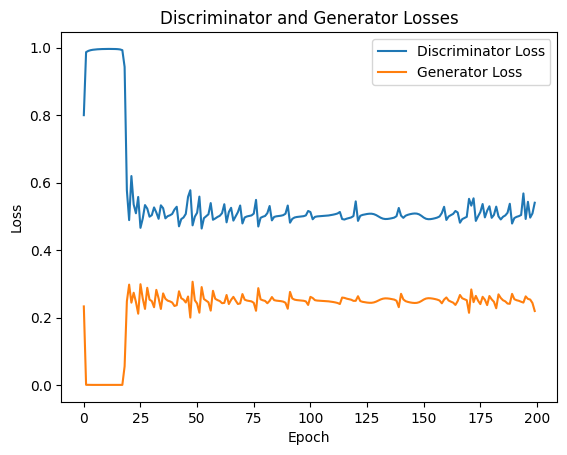

In [39]:
import matplotlib.pyplot as plt

# Plot the discriminator loss
plt.plot(d, label='Discriminator Loss')

# Plot the generator loss
plt.plot(g, label='Generator Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator and Generator Losses')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [40]:
# # Define the file path where you want to save the model
# model_path_g = 'generator_model_epoch200_Carla.h5'
# model_path_d = 'discriminator_model_epoch200_Carla.h5'


# # Save the model
# generator.save(model_path_g)
# discriminator.save(model_path_d)
